라이브러리 import, 학습 데이터 입력 ∙ 데이터 수정

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from bayes_opt import BayesianOptimization
from lightgbm import LGBMRegressor


In [2]:
# 데이터 로드 
#종목코드가 포함된 열은 object형식으로 로드
stock_df = pd.read_csv('/Users/moon/Desktop/Moon SeungHoo/Stock_Machine_Learning/StockData_Setting.csv',low_memory=False)
stock_df_pred = pd.read_csv('/Users/moon/Desktop/Moon SeungHoo/Stock_Machine_Learning/StockData_Pred.csv',low_memory=False)

#labal 데이터프레임
label_df = stock_df['18']
#train 데이터프레임에서 label 값 삭제
stock_df = stock_df.drop({'18','7','0','1'},axis=1)
#학습에 필요한 데이터에서 Date제거
pred_tiker = stock_df_pred['0']
stock_df_pred = stock_df_pred.drop({'0','1','7'},axis=1)
# # #종목코드 int형으로 변환
# stock_df.astype({'0':'int'})
# stock_df_pred.astype({'0':'int'})

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(stock_df, label_df, test_size=0.2, random_state=42)

# SMOTE를 사용해서 데이터 불균형 교정
smote = SMOTE(sampling_strategy='auto',random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test,y_test)

LGBM 하이퍼 파라미터 튜닝(BayesianOptimization)

In [3]:
# from bayes_opt import BayesianOptimization
# from sklearn.metrics import roc_auc_score
# from lightgbm import LGBMRegressor

# bayesian_params = {
#     'colsample_bytree': (0.0,1.0),
#     "learning_rate": (0.001, 0.3),
#     'max_depth': (1,100),
#     'min_child_samples': (1, 200), #하나의 잎에 최소 데이터 개수 (오버피팅 대응)
#     'min_child_weight': (1,20),
#     "num_leaves": (2,512),
#     'reg_alpha': (0,20),
#     'reg_lambda': (0,20),
#     'scale_pos_weight': (0.1,20),
#     'subsample': (0.1,1),
#     'feature_fraction': (0.1,1.0),
#     'bagging_fraction': (0.1,1.0),
#     'bagging_freq':(1,10)
# }

# def lgb_roc_eval(colsample_bytree,learning_rate,max_depth, min_child_samples,min_child_weight, 
#                  num_leaves, reg_lambda, reg_alpha, scale_pos_weight,subsample,feature_fraction,bagging_fraction,bagging_freq):
#   params = {
#       "n_estimators": 500,
#       'colsample_bytree': max(min(colsample_bytree, 1), 0),
#       "learning_rate": learning_rate,
#       'max_depth': int(round(max_depth)),
#       'min_child_samples': int(round(min_child_samples)),
#       'min_child_weight': int(round(min_child_weight)),
#       'num_leaves': int(round(num_leaves)),
#       'reg_lambda': max(reg_lambda, 0),
#       'reg_alpha': max(reg_alpha, 0),
#       "scale_pos_weight": scale_pos_weight,
#       'subsample': max(min(subsample, 1), 0),
#       "feature_fraction": feature_fraction,
#       'bagging_fraction': bagging_fraction,
#       'bagging_freq': round(bagging_freq)
#   }
#   lgb_model = LGBMRegressor(**params)
#   lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric= 'mse', 
#                 early_stopping_rounds= 20)
#   valid_proba = lgb_model.predict(X_test)
#   roc_auc = roc_auc_score(y_test, valid_proba)

#   return roc_auc

# lgbBO = BayesianOptimization(f= lgb_roc_eval, pbounds=bayesian_params, random_state = 42)
# lgbBO.maximize(init_points = 5, n_iter = 25)

# # dictionary에 있는 target값을 모두 추출
# target_list = []
# for result in lgbBO.res:
#     target = result['target']
#     target_list.append(target)
# print(target_list)
# # 가장 큰 target 값을 가지는 순번(index)를 추출
# print('maximum target index:', np.argmax(np.array(target_list)))

# # 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
# max_dict = lgbBO.res[np.argmax(np.array(target_list))]
# print(max_dict)

LGBM Regressor 모델 생성 ∙ 학습

In [4]:
# 교차검증 (StratifiedKFold)
n_split = 5
fk  = KFold(n_splits= n_split)

y_pred = np.zeros(len(X_test_resampled))

for tr_idx,val_idx in fk.split(stock_df,stock_df.index):
    X_train_resampled = stock_df.iloc[tr_idx,:]
    y_train_resampled = label_df[tr_idx]

    X_val = stock_df.iloc[val_idx,:]
    y_val = label_df[val_idx]
    
    #LGBMRegressor 모델 생성
    LGB_R = lgb.LGBMRegressor(boosting_type='gbdt',metric='mse',colsample_bytree=0.48,learning_rate=0.05,max_depth=81,min_child_samples=175,min_child_weight=19,num_leaves=268,
                            reg_alpha=10.15,reg_lambda=7.24,scale_pos_weight=0.61,subsample=0.62,bagging_fraction=0.72,bagging_freq=8,feature_fraction=0.35,num_iterations=5000,n_jobs=8,verbose=100)
                            
    LGB_R.fit(X_train_resampled,y_train_resampled,eval_set=[(X_val,y_val)],eval_metric='mse',early_stopping_rounds=50)
    y_pred += LGB_R.predict(X_test_resampled)/n_split

joblib.dump(LGB_R,'LGBM_Model.pkl')

/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.72, subsample=0.62 will be ignored. Current value: bagging_fraction=0.72
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=0.48 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.72, subsample=0.62 will be ignored. Current value: bagging_fraction=0.72
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=0.48 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000316
[LightGBM] [Debug] init for col-wise cost 0.000035 seconds, init for row-wise cost 0.024043 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005615 seconds.
You ca

/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.72, subsample=0.62 will be ignored. Current value: bagging_fraction=0.72
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=0.48 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.72, subsample=0.62 will be ignored. Current value: bagging_fraction=0.72
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=0.48 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000302
[LightGBM] [Debug] init for col-wise cost 0.000020 seconds, init for row-wise cost 0.024542 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006479 seconds.
You ca

/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.72, subsample=0.62 will be ignored. Current value: bagging_fraction=0.72
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=0.48 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.72, subsample=0.62 will be ignored. Current value: bagging_fraction=0.72
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=0.48 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000293
[LightGBM] [Debug] init for col-wise cost 0.000005 seconds, init for row-wise cost 0.024691 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005359 seconds.
You ca

/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.72, subsample=0.62 will be ignored. Current value: bagging_fraction=0.72
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=0.48 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.72, subsample=0.62 will be ignored. Current value: bagging_fraction=0.72
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=0.48 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000314
[LightGBM] [Debug] init for col-wise cost 0.000057 seconds, init for row-wise cost 0.023655 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005593 seconds.
You ca

/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.72, subsample=0.62 will be ignored. Current value: bagging_fraction=0.72
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=0.48 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.72, subsample=0.62 will be ignored. Current value: bagging_fraction=0.72
[LightGBM] [Warning] feature_fraction is set=0.35, colsample_bytree=0.48 will be ignored. Current value: feature_fraction=0.35
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000274
[LightGBM] [Debug] init for col-wise cost 0.000009 seconds, init for row-wise cost 0.029275 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005535 seconds.
You ca

['LGBM_Model.pkl']

LGBM Regressor 모델 평가 지표

In [5]:
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n',confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

# 평가 지표 계산
preds_id = np.where(y_pred > 0.5,True,False)

get_clf_eval(y_test_resampled,preds_id)

오차행렬:
 [[171768    201]
 [ 65190 106779]]

정확도: 0.8099
정밀도: 0.9981
재현율: 0.6209
F1: 0.7656
AUC: 0.8099


내일 5%이상 오를 종목 예측

In [6]:
def make_six_digit_list(input_list):
    six_digit_list = []

    for item in input_list:
        # 현재 항목의 길이를 확인
        item_str = str(item)
        item_len = len(item_str)

        if item_len < 6:
            # 6자리가 안되는 항목은 앞에 0을 채워서 6자리로 만듭니다.
            zero_padding = '0' * (6 - item_len)
            six_digit_item = zero_padding + item_str
            six_digit_list.append(six_digit_item)
        else:
            # 이미 6자리인 경우 그대로 유지
            six_digit_list.append(item_str)

    return six_digit_list

In [7]:
# 내일 주가 예측
LGBM_M = joblib.load('LGBM_Model.pkl')
pred_X = stock_df_pred
predictions = LGBM_M.predict(pred_X,predict_disable_shape_check=True)
# 5% 이상 오를 종목 식별
threshold = 0.5
rising_stocks = [ticker for i, ticker in enumerate(pred_tiker) if predictions[i] > threshold]
rising_stocks = list(map(str, rising_stocks))
result = list(set(rising_stocks))
result = make_six_digit_list(result)
print("내일 5% 이상 상승할 종목:", result)
print(len(result))

내일 5% 이상 상승할 종목: ['089970', '002900', '052400', '200880', '027050', '138610', '121600', '393210', '005690', '298380', '010100', '305090', '066910', '085660', '357550', '052020', '039420', '145020', '050960', '227610', '008290', '241820', '058610', '205470', '004100', '267270', '131370', '032500', '370090', '005110', '047560', '058850', '002870', '010470', '009140', '098460', '250060', '115440', '179900', '148250', '072770', '389030', '005420', '389500', '239890', '950130', '059090', '001390', '039490', '020710', '065350', '054930', '018670', '094820', '008355', '001550', '027710', '041460', '010060', '103590', '006910', '009620', '030210', '123840', '000430', '068050', '011810', '330860', '199730', '036930', '043100', '066570', '127120', '238120', '109610', '058820', '333430', '056360', '000490', '123700', '002140', '009420', '014680', '094970', '248170', '003780', '263720', '066790', '289080', '286750', '014470', '404950', '277410', '191410', '230240', '244460', '351320', '094860', '0

예측한 종목 검증

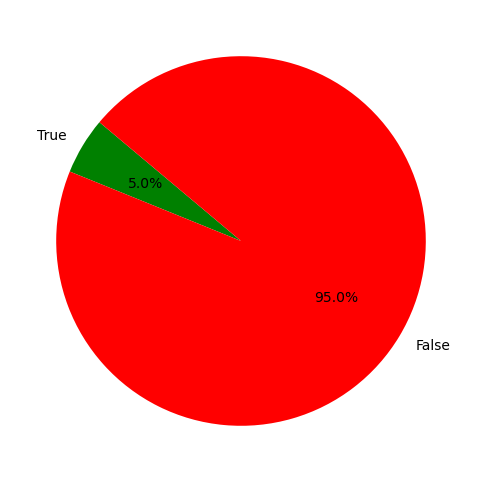

In [11]:
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

def check_price_increase(stock_codes):
    result = {}
    
    for code in stock_codes:
        df = fdr.DataReader(code,'2023-10-12','2023-10-13')
        
        if len(df) < 2:
            result[code] = False
        else:
            today_close = df['Close'].iloc[-1]
            yesterday_close = df['Close'].iloc[-2]
            
            if today_close >= yesterday_close * 1.05 :
                result[code] = True
            else:
                result[code] = False
    return result

result_TF = check_price_increase(result)
result_TF = list(result_TF.values())

# True와 False의 개수를 세어 비율을 계산
true_count = sum(result_TF)
false_count = len(result_TF) - true_count

# 비율을 파이그래프로 표현
labels = ['True', 'False']
sizes = [true_count, false_count]
colors = ['green', 'red']

# 파이차트 그리기
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# 그래프 표시
plt.show()